<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import os

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif False:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

TF version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Found GPU at: /device:GPU:0


In [3]:
import itertools
import os

import numpy as np
pi = np.pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.interpolation import affine_transform
import tensorflow as tf
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator

!pip install --quiet --upgrade git+git://github.com/simoncozens/tensorfont.git
!pip install --quiet fonttools
!pip install --upgrade git+git://github.com/simoncozens/fontParts.git@d444bde6e2a0adbcd9a16593a615a99823089c70
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
import fontParts
import extractor
import defcon
from ufo2ft import compileOTF

from tensorfont import Font

print("✓ Dependencies imported.")

  Cloning git://github.com/simoncozens/fontParts.git (to revision d444bde6e2a0adbcd9a16593a615a99823089c70) to /tmp/pip-req-build-o8e38a6m
  Running command git clone -q git://github.com/simoncozens/fontParts.git /tmp/pip-req-build-o8e38a6m
  Running command git checkout -q d444bde6e2a0adbcd9a16593a615a99823089c70
  Created wheel for fontParts: filename=fontParts-0.9.1.dev0-cp36-none-any.whl size=175279 sha256=fdc6f8fb25db10ac3394647296c442757b6bc50f5dda41de0438b2f7ca746f75
  Stored in directory: /tmp/pip-ephem-wheel-cache-z866nj3w/wheels/f8/18/00/555dac1d1bf8d03d0ec038547c75789c8a1019ea39daed538c
Successfully built fontParts
  Found existing installation: fontParts 0.9.1.dev0
    Uninstalling fontParts-0.9.1.dev0:
      Successfully uninstalled fontParts-0.9.1.dev0
✓ Dependencies imported.


In [4]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [41]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "abgjqrst"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
#glyph_char_list = "abc"

# ==== Create Font ====
factor = 0.8 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 2 
sample_distance_deltas = [-2, 0, 2]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 6
n_v1_orientations = 4
n_v4_scales = 5

Box size: 63 × 129


Spatial frequency scales: [ 0.9         1.43733333  3.04933333  5.736       9.49733333 14.33333333]


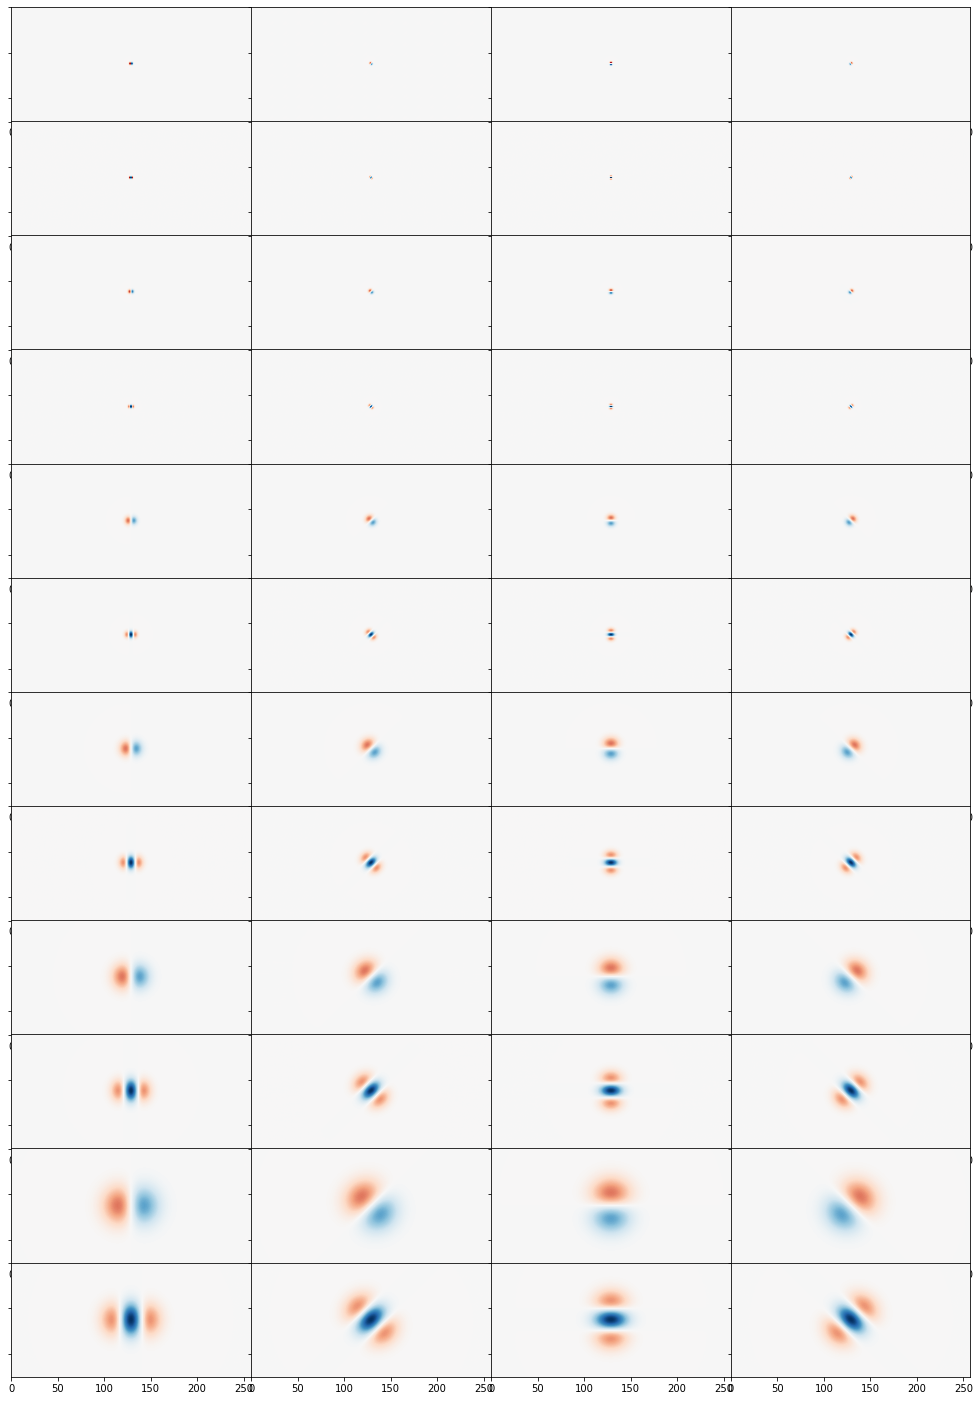

In [73]:
def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_v1_scales):
        min_sigma = 0.9
        max_sigma = box_width / 9
        sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_v1_scales - 1)**2 + min_sigma)
        #sigmas.append((max_sigma - min_sigma) * s / n_v1_scales + min_sigma)
    return np.array(sigmas)

print("Spatial frequency scales:", get_sigmas())

def get_v1_filter_bank(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                             [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]])
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
        y += 0.5 # 0 if box_height % 2 == 0 else 0.5
        x += 0.5 # 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(s, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.

        # First derivative (odd filter/up-down)
        d1_space = np.exp(-(x**2+y**2)/(2*s**2))*x/(2*pi*s**4)
        d1_relu_sum = np.sum(d1_space * (d1_space > 0))
        d1 = np.fft.fft2(np.fft.ifftshift(d1_space + 1j * np.zeros_like(d1_space)))

        # Second derivative (even filter/mexican hat):
        s2 = s * .85 # To make them about the same width
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2_relu_sum = np.sum(d2_space * (d2_space > 0))
        d2 = (d1_relu_sum / d2_relu_sum) * np.fft.fft2(np.fft.ifftshift(d2_space + 1j * np.zeros_like(d2_space)))

        return d1 + 1j*d2

    filter_bank = np.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 30
        fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))

    sigmas = get_sigmas()
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter(sigma, o)
            if display_filters:
                mx = np.max(np.abs(np.imag(np.fft.ifft2(f))))
                ax[s*2, o].imshow(np.real(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()

    return filter_bank.astype(np.complex64)

filter_bank = get_v1_filter_bank(0, display_filters=False)


def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    bdsohw_input_image = input_image[None, None, None, None, :, :]

    # pad image to filter size, which is 2*box_height, 2*box_width (to prevent too much wrapping)
    padded_input = tf.pad(bdsohw_input_image, [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    input_in_freqdomain = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(padded_input, tf.zeros_like(padded_input))))

    padded_result = tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :])

    presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], [2, 3])

    return presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

100%|██████████| 26/26 [00:00<00:00, 6002.42it/s]

  ✓ 26 glyphs rendered.



100%|██████████| 26/26 [00:00<00:00, 13392.10it/s]

  ✓ 26 glyphs measured.



100%|██████████| 26/26 [00:00<00:00, 217.43it/s]

  ✓ 26 glyphs filtered.


Scale: 0


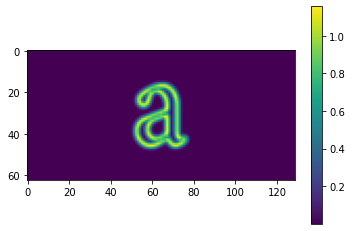

Scale: 1


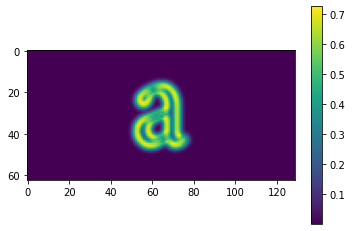

Scale: 2


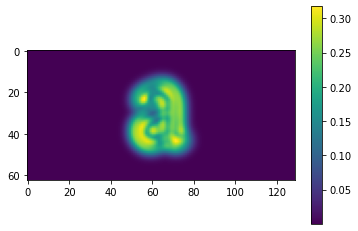

Scale: 3


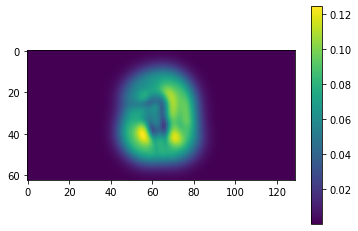

Scale: 4


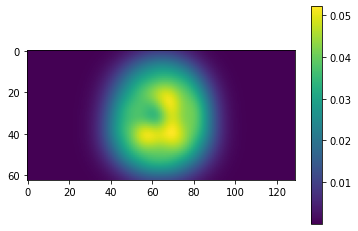

Scale: 5


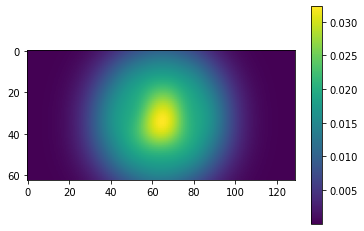

100%|██████████| 26/26 [00:00<00:00, 194.04it/s]


  ✓ 676 pairs assembled.

  ✓ Dataset ready.


In [74]:
# 1. Render glyphs

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

def get_v1_response(glyph_image):
    """Returns a np.array of shape [n_v1_scales, n_v1_orientations, box_height, box_width] and type complex64,
    containing the local responses to the V1 filter bank (after inverse Fourier transform, i.e. in the spatial domain)."""
    with tf.device("/gpu:0"):
        filtered = apply_filter_bank(glyph_image, filter_bank)
    return filtered

glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)
glyph_v1_responses = {c: get_v1_response(glyph_images[c]) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs filtered.", flush=True)

# 1a. Show an example of filtered glyphs
for si in range(n_v1_scales):
    print("Scale:", si)
    plt.imshow(np.sum(np.abs(glyph_v1_responses["a"][si, :, :, :]), (0)))
    plt.colorbar()
    plt.show()

# 2. Assemble pairs

def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance / np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)
    
left_images = []
right_images = []
left_v1_responses = []
right_v1_responses = []
left_translations = []
right_translations = []

for c1 in tqdm(glyph_char_list):
    for c2 in glyph_char_list:
        left_images.append(glyph_images[c1])
        right_images.append(glyph_images[c2])
        left_v1_responses.append(glyph_v1_responses[c1])
        right_v1_responses.append(glyph_v1_responses[c2])

        lt, rt = get_pair_translations(c1, c2, sample_distance_deltas)
        left_translations.append(lt)
        right_translations.append(rt)

print("  ✓", len(glyph_char_list)**2, "pairs assembled.")

# 3. Set up generator to yield pairs, and wrap generator in a tf.Dataset

def return_pair():
    i = 0
    while i < len(left_images):
        yield {
            "left_image": left_images[i],
            "right_image": right_images[i],
            "left_v1_response": left_v1_responses[i],
            "right_v1_response": right_v1_responses[i],
            "left_translations": left_translations[i],
            "right_translations": right_translations[i],
        }
        i = (i + 1) % len(left_images)

dataset = tf.data.Dataset.from_generator(
     return_pair,
     {
      "left_image": tf.float32,
      "right_image": tf.float32,
      "left_v1_response": tf.complex64,
      "right_v1_response": tf.complex64,#
      "left_translations": tf.int32,
      "right_translations": tf.int32,
     },
     {
      "left_image": tf.TensorShape([box_height, box_width]),
      "right_image": tf.TensorShape([box_height, box_width]),
      "left_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "right_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "left_translations": tf.TensorShape([n_sample_distances,]),
      "right_translations": tf.TensorShape([n_sample_distances,])
     },
)

print("\n  ✓ Dataset ready.")

In [75]:
# 4. Apply horizontal translations in the dataset

def translate_4d_image(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, height, width>
    """

    images = tf.tile(input_image[:, :, :, :, None], [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_image.shape[3]] # positive shift: left-shift

    result = tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype)

    # Manually ensure that the width-dimension hasn't changed
    s = list(result.shape)
    s[-1] = box_width
    result.set_shape(s)

    return result

def apply_translations(d):
    d["left_image"] = translate_4d_image(d["left_image"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_image"] = translate_4d_image(d["right_image"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v1_response"] = translate_4d_image(d["left_v1_response"], d["left_translations"])
    d["right_v1_response"] = translate_4d_image(d["right_v1_response"], d["right_translations"])
    del d["left_translations"]
    del d["right_translations"]
    return (d, 0.)  # The zero here doesn't do anything and is just to make Keras happy, because model.fit expects a dataset of 2-tuples where the second entry is the target value.

translated_dataset = dataset.map(apply_translations)

print("dataset shapes:", translated_dataset.element_spec)

dataset shapes: ({'left_image': TensorSpec(shape=(3, 63, 129), dtype=tf.float32, name=None), 'right_image': TensorSpec(shape=(3, 63, 129), dtype=tf.float32, name=None), 'left_v1_response': TensorSpec(shape=(3, 6, 4, 63, 129), dtype=tf.complex64, name=None), 'right_v1_response': TensorSpec(shape=(3, 6, 4, 63, 129), dtype=tf.complex64, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))


In [0]:
# 5. Utility functions
eps = np.finfo(np.float32).tiny

def invspa(t):
    return np.log(np.exp(t) - 1).astype(np.float32)

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def sp(t):
    return tf.nn.softplus(t)

# 6. Generating G-cell fragments
u, v = np.mgrid[-box_height:box_height,-box_width:box_width].astype(np.float32)
u = u / (2*box_width)
v = v / (2*box_width)
r = np.sqrt(u**2 + v**2)[None, None, None, None, None, :, :]
angle = np.arctan2(u, v)[None, None, None, None, None, :, :] # <b, d, s, o, c, h, w>
angles = np.arange(n_v1_orientations)[None, None, None, :, None, None, None].astype(np.float32)/n_v1_orientations

def bg(scales, inner_widths, inner_strengths, angle_mask_widths):
    freq_masks = sp(inner_strengths) * tf.exp(-(r - scales)**2 / (2 * (inner_widths)**2))

    # Uses von-Mises distribution (via Bessel function)
    bp_angle_masks = tf.exp(-angle_mask_widths * tf.cos(angle - pi - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths))
    bn_angle_masks = tf.exp(-angle_mask_widths * tf.cos(angle - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths))

    bp_masks = (freq_masks) * bp_angle_masks
    bn_masks = (freq_masks) * bn_angle_masks

    # Each bp/bn_mask should add up to exactly one.
    bp_masks_normed = bp_masks / (eps + tf.reduce_mean(bp_masks, [0, 1, 2, 3, 5, 6], keepdims=True))
    bn_masks_normed = bn_masks / (eps + tf.reduce_mean(bn_masks, [0, 1, 2, 3, 5, 6], keepdims=True))

    return tf.concat([bp_masks_normed, bn_masks_normed], axis=3)


# 7. V4 layer
class V4Layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(V4Layer, self).__init__(**kwargs)

        self.v1_orientation_weights = self.add_weight(shape=(1, 1, n_v1_scales, n_v1_orientations, 1, 1),
                                                   initializer=tf.keras.initializers.Constant(1.),
                                                   name="v1_orientation_weights",
                                                   trainable=True)

        self.v4_orientation_weights = self.add_weight(shape=(1, 1, 1, n_v1_orientations, n_v4_scales, 1, 1),
                                                   initializer=tf.keras.initializers.Constant(1.),
                                                   name="v4_orientation_weights",
                                                   trainable=True)

        self.scales = self.add_weight(shape=(1, 1, 1, 1, n_v4_scales, 1, 1),
                                      initializer=tf.keras.initializers.Constant(np.array([.8,1.5,2.7,4.2,7.])[None, None, None, None, :, None, None].astype(np.float32)/box_width),
                                      name="scales", trainable=True)
        self.inner_widths = self.add_weight(shape=(1, 1, 1, 1, n_v4_scales, 1, 1),
                                            initializer=tf.keras.initializers.Constant(np.array([.5,0.75,1.35,2.1,3.5])[None, None, None, None, :, None, None].astype(np.float32)/box_width),
                                            name="inner_widths", trainable=True)
        self.inner_strengths = self.add_weight(shape=(1, 1, 1, 1, n_v4_scales, 1, 1),
                                               initializer=tf.keras.initializers.Constant(1.),
                                               name="inner_strengths", trainable=True)
        self.angle_mask_widths = self.add_weight(shape=(1, 1, n_v1_scales, 1, n_v4_scales, 1, 1),
                                                 initializer=tf.keras.initializers.Constant(4.),
                                                 name="angle_mask_widths", trainable=True)


        self.e0 = self.add_weight(shape=((1, 1, n_v1_scales, n_v1_orientations, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                 name="e0",
                                 trainable=True)
        self.e = self.add_weight(shape=((1, 1, n_v1_scales, 2*n_v1_orientations, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(invsp(2.)),
                                 name="e",
                                 trainable=True)
        self.e2 = self.add_weight(shape=((1, 1, 1, 1, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(invsp(2.)),
                                 name="e2",
                                 trainable=True)
        self.scale_weights = self.add_weight(shape=(n_v1_scales, 1, 1, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp(1.)),
                                 name="channel_sizes",
                                 trainable=True)
        self.orientation_weights = self.add_weight(shape=(1, 2*n_v1_orientations, 1, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp(1.)),
                                 name="channel_sizes",
                                 trainable=True)

    def print_weights(self):
        print("printing weights for v4 layer")

    def linking_matrix(self):
        # We now have a matrix K(s, o, c, h, w) that has a bunch of reponses.
        # We want to end up with a matrix L(o, c, h, w) that captures what is going on locally (ideally, skeletons)
        # and in the periphery (ideally, convexities).
        v4_scale_linking = tf.eye(n_v4_scales)[None, None, :, :]
    
        # Now we need a matrix that links each size to each n_v4_scale
        normalized_scale_weights = sp(self.scale_weights) / tf.reduce_sum(sp(self.scale_weights), [-1], keepdims=True)
    
        # And a matrix that links each orientation to each n_v4_scale
        normalized_orientation_weights = sp(self.orientation_weights) / tf.reduce_sum(sp(self.orientation_weights), [-1], keepdims=True)

        return v4_scale_linking * normalized_scale_weights * normalized_orientation_weights

    def call(self, inputs):
        # Step 1: Sum orientations together into V1C sizes:
        norm_ow = tf.nn.relu(self.v1_orientation_weights) / (tf.reduce_sum(tf.nn.relu(self.v1_orientation_weights), axis=[3], keepdims=True) + eps)
        v1c = ((inputs + eps) ** self.e0) * norm_ow

        v1c_mirrored_expanded = tf.pad(tf.concat([v1c]*2, axis=3), [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

        # Temporarily expand into: # <b, d, s, o, c, h, w> where c is the channels per size and orientation
        v1c_mirrored_bg_expanded = (tf.concat([v1c_mirrored_expanded[:, :, :, :, None, :, :]] * n_v4_scales, axis=4)) # used to be self.v1_hra
        
        # v1c_mirrored_expanded: for each channel, we need [2*n_v1_orientations] and then another [2*n_v1_orientations]

        v1c_mirrored_bg_expanded_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(v1c_mirrored_bg_expanded, 0.)))

        # Step 2: Convolve each one of the v1c channels with a particular filter, and its opposite filter.
        # The filters (self.f) are assumed to be in space domain and centered at (0, 0).

        m = bg(self.scales, self.inner_widths, self.inner_strengths, self.angle_mask_widths) * tf.concat([self.v4_orientation_weights] * 2, axis=3)

        m_fft = (tf.signal.fft2d(tf.signal.ifftshift(tf.complex(m, 0.) + eps)) + eps) 

        padded_filtered_inputs = tf.signal.fftshift(tf.signal.ifft2d(v1c_mirrored_bg_expanded_fft * m_fft)) # or should it be 4, 5? # instead of: pfilter
        result = padded_filtered_inputs[:, :, :, :, :,
                           int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                           int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

        primary_result = (tf.nn.relu(tf.math.real(result)) / (box_height * box_width) + eps) ** sp(self.e)

        # Primary result is now L(b, d, s, o, c, h, w)
        # Now sum together the results from neighbouring (or even opposite filters).
        # We want the result to have the shape of L(b, d, 1, o, c, h, w)
        linking_matrix = self.linking_matrix()
        L = tf.einsum("bdsochw,socq->bdqhw", primary_result, eps + tf.nn.relu(linking_matrix))[:, :, None, None, :, :, :]

        Le = (L + eps) ** sp(self.e2) #self.v4_hra(L) # self.v4_hra

        return Le

# 8. Cost layer
class CostLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(CostLayer, self).__init__(**kwargs)
        # <b, s, o, h, w, d>
        self.wp = self.add_weight(shape=((1, 1, 1, 1, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(0.01),
                                 name="wp",
                                 trainable=True)
        self.wn = self.add_weight(shape=((1, 1, 1, 1, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(0.01),
                                 name="wn",
                                 trainable=True)

    def norm(self, i):
        """Normalize the weights.
        This regularization is necessary to keep the optimizer from simply making the weights tiny."""

        v = sp(1e2*i)/1e2

        wpv = tf.reduce_sum(tf.cumsum(sp(1e2*self.wn)/1e2, axis=4, reverse=True) + tf.cumsum(sp(1e2*self.wp)/1e2, axis=4, reverse=True))
        return tf.cumsum(v / wpv, axis=4, reverse=True)

    def print_weights(self):
        print("loss penalties (blue for loss, orange for gains")
        plt.plot(self.norm(self.wp)[0, 0, 0, 0, :, 0, 0])
        plt.plot(self.norm(self.wn)[0, 0, 0, 0, :, 0, 0])
        plt.show()

    def call(self, inputs):
        costs = tf.nn.relu(inputs) * self.norm(self.wp) - tf.nn.relu(-inputs) * self.norm(self.wn)
        return costs

# 9. Set up the actual math

def get_pair_violation(left_v1_response, right_v1_response):
    """Runs the V1 responses through the V4 layer, weights the pair differences via the CostLayer,
    and then returns the worst violation of the "cost-must-be-lowest-for-optimal-distance" principle
    which is then passed to the optimizer."""

    # Feed V1 responses through the V4 layer
    v4 = V4Layer()
    left_v4_response = tf.identity(v4(tf.abs(left_v1_response)), "left_v4_response")
    right_v4_response = tf.identity(v4(tf.abs(right_v1_response)), "right_v4_response")
    pair_v4_response = tf.identity(v4(tf.abs(left_v1_response + right_v1_response)), "pair_v4_response")

    # Compute gains and losses in V4 (of pair, relative to standalone letters).
    pair_diff = tf.identity(left_v4_response + right_v4_response - pair_v4_response, "pair_diff")

    # Compute penalty/reward values for each pair_diff
    cost = CostLayer()
    pair_pixel_cost = tf.identity(cost(pair_diff), "pair_pixel_cost")

    # Sum over all channels and pixels to yield one total cost per <pair, sample_distance>
    total_pair_cost = tf.identity(tf.reduce_sum(pair_pixel_cost, axis=[2, 3, 4, 5, 6]), name="pair_total_cost")

    # Find worst violation of the well
    up_first_ness = (total_pair_cost[:, 1] - total_pair_cost[:, 0])
    down_second_ness = (total_pair_cost[:, 1] - total_pair_cost[:, 2])
    worst_violation = tf.reduce_max(tf.stack([up_first_ness, down_second_ness]), name="worst_violation")

    mean_optimal_penalty = tf.reduce_mean(tf.abs(total_pair_cost[:, 1]))
    
    return worst_violation / (eps + mean_optimal_penalty)

# 10. Set up Keras model and run

def get_keras_model():
    # The translated raw images aren't used in the model, they're just for visualization purposes ...
    left_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_image')
    right_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_image')

    # ... but the translated V1 responses are:
    left_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='left_v1_response', dtype=tf.complex64)
    right_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='right_v1_response', dtype=tf.complex64)

    # This calls the V4 layer, the penalty/reward layer, and finds the max cost
    total_violation = tf.identity(get_pair_violation(left_v1_response, right_v1_response), "total_violation")

    return tf.keras.Model(inputs=[left_v1_response, right_v1_response, left_image, right_image], outputs=(total_violation))

class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, interval):
        self.dataset = dataset
        self.interval = interval
        self.current_data = None

    def get_val(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])([self.current_data["left_v1_response"],
                                                                           self.current_data["right_v1_response"],
                                                                           self.current_data["left_image"],
                                                                           self.current_data["right_image"]])[0]
        return output

    def get_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        l.print_weights()

    def on_epoch_end(self, epoch, logs=None):
        # Only show this stuff every [interval] batches
        if epoch % self.interval != 0:
            return

        print([l.name for l in self.model.layers])
        print(self.model.inputs)
        self.current_data, _ = list(self.dataset.as_numpy_iterator())[0]
        pair_images = self.current_data["left_image"] + self.current_data["right_image"]

        plt.imshow(pair_images[0, 0, :, :])
        plt.imshow(tf.reduce_sum(tf.abs(self.current_data["left_v1_response"][0, 1, 0, :, :, :]), [0]), alpha=.6)
        plt.show()
        plt.imshow(pair_images[0, 1, :, :])
        plt.imshow(tf.reduce_sum(tf.abs(self.current_data["left_v1_response"][0, 1, 2, :, :, :]), [0]), alpha=.6)
        plt.show()
        plt.imshow(pair_images[0, 2, :, :])
        plt.imshow(tf.reduce_sum(tf.abs(self.current_data["left_v1_response"][0, 1, n_v1_scales - 2, :, :, :]), [0]), alpha=.6)
        plt.show()

        print("\nPair DIFFS:")
        pair_cost = self.get_val("pair_pixel_cost")
        plt.imshow(pair_images[0, 0, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 0, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        pair_cost = self.get_val("pair_pixel_cost")
        plt.imshow(pair_images[0, 1, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 1, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        pair_cost = self.get_val("pair_pixel_cost")
        plt.imshow(pair_images[0, 2, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 2, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()

        fs = 16
        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        pair_diff = self.get_val("pair_diff")
        maxv = tf.reduce_max(pair_diff)
        minv = tf.reduce_min(pair_diff)
        ex = max(abs(maxv), abs(minv))
        print("RAW LOSSES for size")
        for j in range(n_v4_scales):
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(pair_diff[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
        plt.show()

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("RAW LOSSES for size, without min/max limit")
        for j in range(n_v4_scales):
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(pair_diff[0, 1, 0, 0, j, :, :], alpha=0.7)
        plt.show()

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("LEFT GLYPH for size, without min/max limit")
        for j in range(n_v4_scales):
            print("Channel", j, "max", tf.reduce_max(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :]), "sum", tf.reduce_sum(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :]))
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :], alpha=0.7)
        plt.show()

        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        maxv = tf.reduce_max(pair_cost)
        minv = tf.reduce_min(pair_cost)
        ex = max(abs(maxv), abs(minv))
        print("COST of DIFF for size")
        for j in range(n_v4_scales):
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(pair_cost[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
        plt.show()

        self.print_weights("v4_layer")

        print("costs")
        print("worst violation", self.get_val("worst_violation"))
        plt.plot(np.transpose(self.get_val("pair_total_cost")))
        plt.show()

        print("raw_losses")
        plt.plot(tf.reshape(tf.einsum("bdsoc->dbsoc", tf.reduce_sum(pair_diff, [5,6])), [n_sample_distances, batch_size*n_v4_scales]))
        plt.show()

        self.print_weights("cost_layer")

model = get_keras_model()
model.compile(loss=(lambda _, c: c), optimizer=tf.keras.optimizers.Adam(.001))

testing = 0

prepared_dataset = translated_dataset.shuffle(batch_size).batch(batch_size).prefetch(batch_size)

history = model.fit(prepared_dataset,
                    callbacks=[MonitorProgressCallback(prepared_dataset.take(1), 1 if testing else 5)],
                    epochs=(1 if testing else 1000),
                    steps_per_epoch=(1 if testing else 20), use_multiprocessing=False)